In [1]:
import tensorflow as tf

2023-08-22 15:33:57.185194: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-22 15:33:57.213987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 15:33:58.294366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.13.0'

In [3]:
import glob
# import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
# from tensorflow.python.keras import layers
from tensorflow.keras import layers, activations
import time
import nibabel as nib
from tqdm import tqdm
import gc
from scipy.ndimage import binary_erosion
from IPython import display
import datetime

import model

In [4]:
subjects = [ f.name for f in os.scandir('./Data') if f.is_dir() and f.name != '.ipynb_checkpoints']

e_or_o = 0

p_size_i = 8
p_size_o = 8

print(subjects)

['390645', '545345', '106016', '120111', '101915', '351938', '705341']


In [5]:
subjects_lr = []
subjects_hr = []
subjects_masks = []

subjects_preproc_values_lr = []
subjects_preproc_values_hr = []

subjects_t1_preproc_values = []

for subj in subjects:

    h4_imgs = []
    h4_imgs_lr = []
    dti_imgs = []
    dti_imgs_lr = []

    # DTI normalisation metrics pre-normalisation (storing max and min values in the mask) - Store for HR only
    dti_preprocs_hr = np.zeros((6,2))
    dti_preprocs_lr = np.zeros((6,2))

    print("Loading Subject {}".format(subj))
    
    for i in range(1,9):
    
        dti_data = np.array(nib.load("Data/{}/T1w/Diffusion/dt_all_{}.nii".format(subj,i)).get_fdata())
        dti_data_lr = np.array(nib.load("Data/{}/T1w/Diffusion/dt_all_lowres_2_{}.nii".format(subj,i)).get_fdata())
    
        # if i > 1:
        #     dti_data[dti_imgs[0] < 0] = 0
        #     dti_data_lr[dti_imgs[0] < 0] = 0
    
        dti_imgs.append(dti_data)
        dti_imgs_lr.append(dti_data_lr)
    
        dti_data = None
        dti_data_lr = None
    
    for i in range(1,25):
    
        h4_data = np.array(nib.load("Data/{}/T1w/Diffusion/h4_all_{}.nii".format(subj,str(i).zfill(2))).get_fdata())
        h4_data_lr = np.array(nib.load("Data/{}/T1w/Diffusion/h4_all_lowres_2_{}.nii".format(subj,str(i).zfill(2))).get_fdata())
    
        # if i > 1:
        #     h4_data[h4_data[0] < 0] = 0
        #     h4_data_lr[h4_data[0] < 0] = 0
        
        h4_imgs.append(h4_data)
        h4_imgs_lr.append(h4_data_lr)
    
        h4_data = None
        h4_data_lr = None
    
    h4_imgs = np.array(h4_imgs).transpose((1,2,3,0))
    h4_imgs_lr = np.array(h4_imgs_lr).transpose((1,2,3,0))
    
    dti_imgs = np.array(dti_imgs).transpose((1,2,3,0))
    dti_imgs_lr = np.array(dti_imgs_lr).transpose((1,2,3,0))
    
    mask = h4_imgs[...,0]

    binmask = np.zeros(mask.shape)

    binmask[mask >= 0] = 1

    mask = binary_erosion(binmask, structure=np.ones((5,5,5),np.uint8),iterations = 1)

    binmask = None

    # Calculate DTI ranges and normalise to range [0,1]
    for i in range(2,8):

        dti_preprocs_lr[i-2,:] = np.array([np.min(mask*dti_imgs_lr[...,i]), np.max(mask*dti_imgs_lr[...,i])])
        dti_imgs_lr[mask>0, i] = (dti_imgs_lr[mask>0, i] - dti_preprocs_lr[i-2,0] + 0.0001) / (dti_preprocs_lr[i-2,1] - dti_preprocs_lr[i-2,0])
        dti_imgs_lr[mask==0, i] = 0

        dti_preprocs_hr[i-2,:] = np.array([np.min(mask*dti_imgs[...,i]), np.max(mask*dti_imgs[...,i])])
        dti_imgs[mask>0, i] = (dti_imgs[mask>0, i] - dti_preprocs_hr[i-2,0] + 0.0001) / (dti_preprocs_hr[i-2,1] - dti_preprocs_hr[i-2,0])
        dti_imgs[mask==0, i] = 0


    t1w = nib.load("Data/{}/T1w/Diffusion/t1w.nii".format(subj))
    
    t1w_data = np.array(t1w.get_fdata())
    
    t1w_data_format = np.concatenate(
        (t1w_data[::2,::2,::2, None], t1w_data[::2,::2,1::2, None],
         t1w_data[::2,1::2,::2, None], t1w_data[::2,1::2,1::2, None],
         t1w_data[1::2,::2,::2, None], t1w_data[1::2,::2,1::2, None],
         t1w_data[1::2,1::2,::2, None], t1w_data[1::2,1::2,1::2, None]),
        axis=-1)

    t1w_preprocs = np.array([np.min(t1w_data_format*mask[...,None]), np.max(t1w_data_format*mask[...,None])])
    
    subjects_t1_preproc_values.append(t1w_preprocs)    
    t1w_data_format[mask>0, :] = (t1w_data_format[mask>0, :] - t1w_preprocs[0] + 0.0001) / (t1w_preprocs[1] - t1w_preprocs[0])

    subjects_preproc_values_lr.append(dti_preprocs_lr)
    subjects_preproc_values_hr.append(dti_preprocs_hr)

    lowres_input = np.concatenate((dti_imgs_lr[...,2:], t1w_data_format), axis=-1)
    hires_output = np.copy(dti_imgs[...,2:])
    
    # lowres_input = np.concatenate((h4_imgs_lr[...,2:], dti_imgs_lr[...,2:], t1w_data_format), axis=-1)
    # hires_output = np.copy(h4_imgs[...,2:])

    subjects_lr.append(lowres_input)
    subjects_hr.append(hires_output)
    subjects_masks.append(mask)


Loading Subject 390645
Loading Subject 545345
Loading Subject 106016
Loading Subject 120111
Loading Subject 101915
Loading Subject 351938
Loading Subject 705341


In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv3D(64, (5, 5, 5), strides=(2, 2, 2), padding='same',
                                     input_shape=[5, 5, 5, 22]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    # print(model.input_shape, model.output_shape)

    model.add(layers.Conv3D(128, (5, 5, 5), strides=(2, 2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    # print(model.output_shape)\n",

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation=activations.sigmoid))

    print(model.output_shape)

    return model



# input_layer = tf.keras.Input(shape=(32, 32, 32, 36))
# output_layer = model.unet3d(input_layer, 36)

# generator = tf.keras.Model(input_layer, output_layer)
generator = model.generator_enc_dec(14,6,2*p_size_i+e_or_o)
discriminator = model.simple_discriminator(6,2*p_size_o+e_or_o)

2023-08-22 15:34:15.513599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-22 15:34:15.529252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-22 15:34:15.529362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(None, 16, 16, 16, 6)
(None, 1)


In [7]:
cross_entropy_gen = tf.keras.losses.BinaryCrossentropy()
cross_entropy_disc = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(cross_entropy_gen(tf.ones_like(real_output), real_output))
    fake_loss = tf.reduce_mean(cross_entropy_gen(tf.zeros_like(fake_output), fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.reduce_mean(cross_entropy_gen(tf.ones_like(fake_output), fake_output))

# cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits

# def discriminator_loss(real_output, fake_output):
#     real_loss = tf.reduce_mean(cross_entropy(labels=tf.ones_like(real_output), logits=real_output))
#     fake_loss = tf.reduce_mean(cross_entropy(labels=tf.zeros_like(fake_output), logits=fake_output))
#     total_loss = real_loss + fake_loss
#     return total_loss

# def generator_loss(fake_output):
#     return cross_entropy(labels=tf.ones_like(fake_output), logits=fake_output)

In [8]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=50*2000,
    decay_rate=0.1
)

generator_optimizer = tf.keras.optimizers.Adam(lr_schedule)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [9]:
checkpoint_dir = './training_checkpoints_encdec'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

gen_loss_metric = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
# gen_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy('gen_accuracy')

disc_loss_metric = tf.keras.metrics.Mean('disc_loss', dtype=tf.float32)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = './logs/gradient_tape_encdec/' + current_time + '/train'
summary_writer = tf.summary.create_file_writer(log_dir)

In [10]:
@tf.function
def train_step(lr_patch, hr_patch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(lr_patch, training=True)

      real_output = discriminator(hr_patch, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gen_loss_metric(gen_loss)
    # gen_accuracy_metric(hr_patch, generated_images)

    disc_loss_metric(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

@tf.function
def train_step_gen(lr_patch, hr_patch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(lr_patch, training=True)

        real_output = discriminator(hr_patch, training=False)
        fake_output = discriminator(generated_images, training=False)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss, disc_loss

@tf.function
def train_step_disc(lr_patch, hr_patch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(lr_patch, training=False)

        real_output = discriminator(hr_patch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [11]:
def train(data, epochs):

  gen_train_mode = False

  best_cost = np.Inf
    
  for epoch in range(epochs):

    if epoch > 0 and epoch % 2 == 0:
        gen_train_mode = not gen_train_mode
      
    start = time.time()

    print("Epoch: {}".format(epoch+1))

    print("Learning rate:", generator_optimizer.learning_rate.numpy())


    mean_g_loss = 0.0
    mean_d_loss = 0.0
    total_cost = 0.0

    # [sel_indices, subjects_lr, subjects_hr, subjects_masks]

    randsels = np.random.choice(data[0].shape[0],data[0].shape[0]//4)

    lr_patches = []
    hr_patches = []

    for prog, index in enumerate(tqdm(randsels)):

        if (prog+1) % 8 != 0 or prog == (len(randsels) - 1):

            (s, i, j, k) = data[0][index]
        
            lr_patch = np.copy(data[1][s][
                                    i - p_size_i - e_or_o : i + p_size_i,
                                    j - p_size_i - e_or_o : j + p_size_i,
                                    k - p_size_i - e_or_o : k + p_size_i, :]) * \
            np.copy(data[3][s][
                                    i - p_size_i - e_or_o : i + p_size_i,
                                    j - p_size_i - e_or_o : j + p_size_i,
                                    k - p_size_i - e_or_o : k + p_size_i, None])
                               
        
            hr_patch = np.copy(data[2][s][
                                    i - p_size_o - e_or_o : i + p_size_o,
                                    j - p_size_o - e_or_o : j + p_size_o,
                                    k - p_size_o - e_or_o : k + p_size_o, :]) * \
            np.copy(data[3][s][
                                    i - p_size_o - e_or_o : i + p_size_o,
                                    j - p_size_o - e_or_o : j + p_size_o,
                                    k - p_size_o - e_or_o : k + p_size_o, None])

            lr_patches.append(lr_patch)
            hr_patches.append(hr_patch)
            
            continue
        
        lr_patches = tf.convert_to_tensor(np.array(lr_patches), dtype=tf.float32)
        hr_patches = tf.convert_to_tensor(np.array(hr_patches), dtype=tf.float32)

        g_loss, d_loss = train_step(lr_patches, hr_patches)

        with summary_writer.as_default():
            tf.summary.scalar('gen_loss', gen_loss_metric.result(), step=epoch)
            tf.summary.scalar('disc_loss', disc_loss_metric.result(), step=epoch)
        
        # if gen_train_mode:
        #     g_loss, d_loss = train_step_gen(lr_patch, hr_patch)
        # else:
        #     g_loss, d_loss = train_step_disc(lr_patch, hr_patch)
        
        mean_g_loss = mean_g_loss + g_loss
        mean_d_loss = mean_d_loss + d_loss

        y_preds = generator(lr_patches, training=False)

        total_cost = total_cost + tf.reduce_mean(tf.square(hr_patches - y_preds))

        lr_patches = []
        hr_patches = []
      
    # Save the model every 5 epochs
    # if (epoch + 1) % 5 == 0:
    if best_cost < total_cost:
      checkpoint.save(file_prefix = checkpoint_prefix)
      best_cost = total_cost

    # print('Generator Loss is {}'.format(float(mean_g_loss/len(randsels))))
    # print('Discriminator Loss is {}'.format(float(mean_d_loss/len(randsels))))

    print('Generator Error Metric is {}'.format(float(total_cost/(len(randsels)//4))))
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [12]:
# subjects_lr
# subjects_hr
# subjects_masks

In [13]:
(xsize, ysize, zsize, comp) = subjects_lr[0].shape

# split_indices = [(i, j, k)
#                  for k in np.arange(p_size_i+1,zsize-p_size_i+1,2*p_size_o+1)       
#                  for j in np.arange(p_size_i+1,ysize-p_size_i+1,2*p_size_o+1)
#                  for i in np.arange(p_size_i+1,xsize-p_size_i+1,2*p_size_o+1)
#                 ]

split_indices = [(i, j, k)
                 for k in np.arange(p_size_i+1,zsize-p_size_i+e_or_o,2*p_size_o+e_or_o)       
                 for j in np.arange(p_size_i+1,ysize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                 for i in np.arange(p_size_i+1,xsize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                ]

sel_indices = []

for s in range(len(subjects_lr)):
    for (i, j, k) in split_indices:
        ipatch_mask = subjects_masks[s][
            i - p_size_o - e_or_o : i + p_size_o,
            j - p_size_o - e_or_o : j + p_size_o,
            k - p_size_o - e_or_o : k + p_size_o]
    
        if np.max(ipatch_mask) > 0:
            sel_indices.append((s,i,j,k))

sel_indices = np.array(sel_indices)

In [14]:
train([sel_indices, subjects_lr, subjects_hr, subjects_masks], 600)

Epoch: 1
Learning rate: 0.001


  0%|                                                   | 0/500 [00:00<?, ?it/s]2023-08-22 15:34:18.266796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-22 15:34:19.148361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-22 15:34:19.360888: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f83efc3fd50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-22 15:34:19.360908: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-08-22 15:34:19.364422: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-22 15:34:19.543960: I ./tensorflow/compiler/jit/device_compiler.h:186] Comp

Generator Error Metric is 0.1482345461845398
Time for epoch 1 is 9.63584017753601 sec
Epoch: 2
Learning rate: 0.0009985964


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 222.84it/s]


Generator Error Metric is 0.13862740993499756
Time for epoch 2 is 2.245806932449341 sec
Epoch: 3
Learning rate: 0.0009971719


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 223.53it/s]


Generator Error Metric is 0.1344701200723648
Time for epoch 3 is 2.238743782043457 sec
Epoch: 4
Learning rate: 0.0009957494


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 215.61it/s]


Generator Error Metric is 0.11395850032567978
Time for epoch 4 is 2.3211731910705566 sec
Epoch: 5
Learning rate: 0.0009943288


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 174.82it/s]


Generator Error Metric is 0.14497049152851105
Time for epoch 5 is 2.8625404834747314 sec
Epoch: 6
Learning rate: 0.0009929102


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 160.51it/s]


Generator Error Metric is 0.15287747979164124
Time for epoch 6 is 3.1176598072052 sec
Epoch: 7
Learning rate: 0.0009914938


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 177.92it/s]


Generator Error Metric is 0.1287103295326233
Time for epoch 7 is 2.811917781829834 sec
Epoch: 8
Learning rate: 0.0009900794


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 211.19it/s]


Generator Error Metric is 0.15120576322078705
Time for epoch 8 is 2.369459390640259 sec
Epoch: 9
Learning rate: 0.0009886669


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 215.58it/s]


Generator Error Metric is 0.18736429512500763
Time for epoch 9 is 2.3215744495391846 sec
Epoch: 10
Learning rate: 0.0009872565


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 220.48it/s]


Generator Error Metric is 0.17094209790229797
Time for epoch 10 is 2.2699413299560547 sec
Epoch: 11
Learning rate: 0.0009858481


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 222.52it/s]


Generator Error Metric is 0.100225068628788
Time for epoch 11 is 2.2489914894104004 sec
Epoch: 12
Learning rate: 0.0009844417


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 223.92it/s]


Generator Error Metric is 0.13874311745166779
Time for epoch 12 is 2.234865188598633 sec
Epoch: 13
Learning rate: 0.0009830373


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.29it/s]


Generator Error Metric is 0.11398646980524063
Time for epoch 13 is 2.231356620788574 sec
Epoch: 14
Learning rate: 0.000981635


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 176.17it/s]


Generator Error Metric is 0.19121333956718445
Time for epoch 14 is 2.840503454208374 sec
Epoch: 15
Learning rate: 0.0009802346


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 217.89it/s]


Generator Error Metric is 0.17071111500263214
Time for epoch 15 is 2.2968966960906982 sec
Epoch: 16
Learning rate: 0.0009788362


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.36it/s]


Generator Error Metric is 0.15807689726352692
Time for epoch 16 is 2.210761070251465 sec
Epoch: 17
Learning rate: 0.0009774398


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.11it/s]


Generator Error Metric is 0.2108812779188156
Time for epoch 17 is 2.2132811546325684 sec
Epoch: 18
Learning rate: 0.00097604544


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.55it/s]


Generator Error Metric is 0.18033157289028168
Time for epoch 18 is 2.1991851329803467 sec
Epoch: 19
Learning rate: 0.000974653


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.40it/s]


Generator Error Metric is 0.18407167494297028
Time for epoch 19 is 2.2102537155151367 sec
Epoch: 20
Learning rate: 0.0009732626


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.46it/s]


Generator Error Metric is 0.116715207695961
Time for epoch 20 is 2.209838628768921 sec
Epoch: 21
Learning rate: 0.00097187405


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.43it/s]


Generator Error Metric is 0.08793234080076218
Time for epoch 21 is 2.2201645374298096 sec
Epoch: 22
Learning rate: 0.00097048766


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.73it/s]


Generator Error Metric is 0.12274222820997238
Time for epoch 22 is 2.216999053955078 sec
Epoch: 23
Learning rate: 0.00096910313


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.25it/s]


Generator Error Metric is 0.17531074583530426
Time for epoch 23 is 2.221473455429077 sec
Epoch: 24
Learning rate: 0.0009677207


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.87it/s]


Generator Error Metric is 0.21071076393127441
Time for epoch 24 is 2.2158608436584473 sec
Epoch: 25
Learning rate: 0.0009663402


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.87it/s]


Generator Error Metric is 0.20594944059848785
Time for epoch 25 is 2.215557336807251 sec
Epoch: 26
Learning rate: 0.0009649616


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.08it/s]


Generator Error Metric is 0.14321164786815643
Time for epoch 26 is 2.2136621475219727 sec
Epoch: 27
Learning rate: 0.000963585


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.54it/s]


Generator Error Metric is 0.13429485261440277
Time for epoch 27 is 2.2088723182678223 sec
Epoch: 28
Learning rate: 0.0009622103


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 176.65it/s]


Generator Error Metric is 0.0998355895280838
Time for epoch 28 is 2.832641124725342 sec
Epoch: 29
Learning rate: 0.00096083764


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 164.48it/s]


Generator Error Metric is 0.09628726541996002
Time for epoch 29 is 3.0418245792388916 sec
Epoch: 30
Learning rate: 0.0009594669


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 160.36it/s]


Generator Error Metric is 0.0862073078751564
Time for epoch 30 is 3.119935989379883 sec
Epoch: 31
Learning rate: 0.00095809816


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 170.44it/s]


Generator Error Metric is 0.10174774378538132
Time for epoch 31 is 2.9352920055389404 sec
Epoch: 32
Learning rate: 0.0009567314


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 214.36it/s]


Generator Error Metric is 0.10195478796958923
Time for epoch 32 is 2.334097385406494 sec
Epoch: 33
Learning rate: 0.00095536653


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.58it/s]


Generator Error Metric is 0.061619482934474945
Time for epoch 33 is 2.2085084915161133 sec
Epoch: 34
Learning rate: 0.0009540036


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.42it/s]


Generator Error Metric is 0.05449220910668373
Time for epoch 34 is 2.210078477859497 sec
Epoch: 35
Learning rate: 0.0009526426


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.15it/s]


Generator Error Metric is 0.05213845521211624
Time for epoch 35 is 2.213020086288452 sec
Epoch: 36
Learning rate: 0.00095128355


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 170.38it/s]


Generator Error Metric is 0.10919580608606339
Time for epoch 36 is 2.9367382526397705 sec
Epoch: 37
Learning rate: 0.0009499265


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.44it/s]


Generator Error Metric is 0.12746410071849823
Time for epoch 37 is 3.0062355995178223 sec
Epoch: 38
Learning rate: 0.00094857137


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.55it/s]


Generator Error Metric is 0.06267686188220978
Time for epoch 38 is 3.0043046474456787 sec
Epoch: 39
Learning rate: 0.0009472181


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.49it/s]


Generator Error Metric is 0.05890221148729324
Time for epoch 39 is 3.0054709911346436 sec
Epoch: 40
Learning rate: 0.00094586686


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 213.11it/s]


Generator Error Metric is 0.07135006785392761
Time for epoch 40 is 2.3483572006225586 sec
Epoch: 41
Learning rate: 0.00094451755


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.32it/s]


Generator Error Metric is 0.053200412541627884
Time for epoch 41 is 2.220947027206421 sec
Epoch: 42
Learning rate: 0.00094317005


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.46it/s]


Generator Error Metric is 0.07865362614393234
Time for epoch 42 is 2.2294278144836426 sec
Epoch: 43
Learning rate: 0.0009418245


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.98it/s]


Generator Error Metric is 0.057907383888959885
Time for epoch 43 is 2.214765787124634 sec
Epoch: 44
Learning rate: 0.00094048097


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.04it/s]


Generator Error Metric is 0.0592765286564827
Time for epoch 44 is 2.2240703105926514 sec
Epoch: 45
Learning rate: 0.0009391393


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.53it/s]


Generator Error Metric is 0.08802681416273117
Time for epoch 45 is 2.209073781967163 sec
Epoch: 46
Learning rate: 0.0009377996


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.95it/s]


Generator Error Metric is 0.08837318420410156
Time for epoch 46 is 2.2150349617004395 sec
Epoch: 47
Learning rate: 0.00093646167


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.96it/s]


Generator Error Metric is 0.08161072432994843
Time for epoch 47 is 2.204951286315918 sec
Epoch: 48
Learning rate: 0.00093512575


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.82it/s]


Generator Error Metric is 0.06440450996160507
Time for epoch 48 is 2.225986957550049 sec
Epoch: 49
Learning rate: 0.00093379174


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.44it/s]


Generator Error Metric is 0.057955626398324966
Time for epoch 49 is 2.2002928256988525 sec
Epoch: 50
Learning rate: 0.00093245954


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.30it/s]


Generator Error Metric is 0.0844438374042511
Time for epoch 50 is 2.2016608715057373 sec
Epoch: 51
Learning rate: 0.0009311293


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.93it/s]


Generator Error Metric is 0.07947713136672974
Time for epoch 51 is 2.2054474353790283 sec
Epoch: 52
Learning rate: 0.00092980097


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.28it/s]


Generator Error Metric is 0.05813106149435043
Time for epoch 52 is 2.231473922729492 sec
Epoch: 53
Learning rate: 0.0009284746


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.10it/s]


Generator Error Metric is 0.06739793717861176
Time for epoch 53 is 2.2132930755615234 sec
Epoch: 54
Learning rate: 0.0009271501


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.46it/s]


Generator Error Metric is 0.06189654394984245
Time for epoch 54 is 2.2097487449645996 sec
Epoch: 55
Learning rate: 0.00092582736


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.19it/s]


Generator Error Metric is 0.05986849218606949
Time for epoch 55 is 2.2122182846069336 sec
Epoch: 56
Learning rate: 0.00092450663


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.57it/s]


Generator Error Metric is 0.06249614432454109
Time for epoch 56 is 2.218705654144287 sec
Epoch: 57
Learning rate: 0.00092318765


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.51it/s]


Generator Error Metric is 0.06957373023033142
Time for epoch 57 is 2.2092487812042236 sec
Epoch: 58
Learning rate: 0.0009218707


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.07it/s]


Generator Error Metric is 0.08776260912418365
Time for epoch 58 is 2.204033613204956 sec
Epoch: 59
Learning rate: 0.00092055555


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.60it/s]


Generator Error Metric is 0.07498820126056671
Time for epoch 59 is 2.208430767059326 sec
Epoch: 60
Learning rate: 0.00091924233


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.05it/s]


Generator Error Metric is 0.07266605645418167
Time for epoch 60 is 2.2239599227905273 sec
Epoch: 61
Learning rate: 0.000917931


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.79it/s]


Generator Error Metric is 0.06478793174028397
Time for epoch 61 is 2.1969375610351562 sec
Epoch: 62
Learning rate: 0.0009166214


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.82it/s]


Generator Error Metric is 0.06993591785430908
Time for epoch 62 is 2.1967639923095703 sec
Epoch: 63
Learning rate: 0.00091531384


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.51it/s]


Generator Error Metric is 0.07259196043014526
Time for epoch 63 is 2.199702739715576 sec
Epoch: 64
Learning rate: 0.000914008


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.09it/s]


Generator Error Metric is 0.06709430366754532
Time for epoch 64 is 2.203627109527588 sec
Epoch: 65
Learning rate: 0.0009127041


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.59it/s]


Generator Error Metric is 0.05030019208788872
Time for epoch 65 is 2.199129343032837 sec
Epoch: 66
Learning rate: 0.0009114021


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.56it/s]


Generator Error Metric is 0.0566958449780941
Time for epoch 66 is 2.198913335800171 sec
Epoch: 67
Learning rate: 0.00091010187


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.73it/s]


Generator Error Metric is 0.05939243733882904
Time for epoch 67 is 2.2068653106689453 sec
Epoch: 68
Learning rate: 0.00090880354


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.12it/s]


Generator Error Metric is 0.05544617399573326
Time for epoch 68 is 2.212740659713745 sec
Epoch: 69
Learning rate: 0.0009075071


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 228.26it/s]


Generator Error Metric is 0.04852663353085518
Time for epoch 69 is 2.1920700073242188 sec
Epoch: 70
Learning rate: 0.00090621243


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.61it/s]


Generator Error Metric is 0.05052965506911278
Time for epoch 70 is 2.198235511779785 sec
Epoch: 71
Learning rate: 0.0009049196


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 219.10it/s]


Generator Error Metric is 0.053397782146930695
Time for epoch 71 is 2.2836833000183105 sec
Epoch: 72
Learning rate: 0.0009036287


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 201.53it/s]


Generator Error Metric is 0.05391503497958183
Time for epoch 72 is 2.4828507900238037 sec
Epoch: 73
Learning rate: 0.0009023396


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 215.43it/s]


Generator Error Metric is 0.062301862984895706
Time for epoch 73 is 2.3233444690704346 sec
Epoch: 74
Learning rate: 0.0009010523


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 221.28it/s]


Generator Error Metric is 0.053083471953868866
Time for epoch 74 is 2.261174201965332 sec
Epoch: 75
Learning rate: 0.0008997669


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 213.28it/s]


Generator Error Metric is 0.053526610136032104
Time for epoch 75 is 2.346013069152832 sec
Epoch: 76
Learning rate: 0.0008984833


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 216.38it/s]


Generator Error Metric is 0.05237884074449539
Time for epoch 76 is 2.312302589416504 sec
Epoch: 77
Learning rate: 0.0008972016


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 219.65it/s]


Generator Error Metric is 0.05547555163502693
Time for epoch 77 is 2.2779412269592285 sec
Epoch: 78
Learning rate: 0.00089592155


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 220.38it/s]


Generator Error Metric is 0.0790567696094513
Time for epoch 78 is 2.2703163623809814 sec
Epoch: 79
Learning rate: 0.00089464354


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 221.30it/s]


Generator Error Metric is 0.07037173211574554
Time for epoch 79 is 2.2609941959381104 sec
Epoch: 80
Learning rate: 0.0008933672


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 218.97it/s]


Generator Error Metric is 0.0649925246834755
Time for epoch 80 is 2.285047769546509 sec
Epoch: 81
Learning rate: 0.00089209276


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 221.00it/s]


Generator Error Metric is 0.05383848026394844
Time for epoch 81 is 2.26405930519104 sec
Epoch: 82
Learning rate: 0.0008908201


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 220.92it/s]


Generator Error Metric is 0.0459388792514801
Time for epoch 82 is 2.265073776245117 sec
Epoch: 83
Learning rate: 0.0008895493


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 221.27it/s]


Generator Error Metric is 0.048864077776670456
Time for epoch 83 is 2.261833906173706 sec
Epoch: 84
Learning rate: 0.00088828034


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 220.16it/s]


Generator Error Metric is 0.05563591048121452
Time for epoch 84 is 2.2729406356811523 sec
Epoch: 85
Learning rate: 0.00088701304


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.75it/s]


Generator Error Metric is 0.10162408649921417
Time for epoch 85 is 2.216660261154175 sec
Epoch: 86
Learning rate: 0.00088574766


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.63it/s]


Generator Error Metric is 0.08745375275611877
Time for epoch 86 is 2.198474645614624 sec
Epoch: 87
Learning rate: 0.00088448403


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.79it/s]


Generator Error Metric is 0.07963687926530838
Time for epoch 87 is 2.1970584392547607 sec
Epoch: 88
Learning rate: 0.00088322227


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.96it/s]


Generator Error Metric is 0.05231647193431854
Time for epoch 88 is 2.1952579021453857 sec
Epoch: 89
Learning rate: 0.0008819623


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.28it/s]


Generator Error Metric is 0.05630873143672943
Time for epoch 89 is 2.231255292892456 sec
Epoch: 90
Learning rate: 0.0008807041


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.86it/s]


Generator Error Metric is 0.06724365800619125
Time for epoch 90 is 3.016638994216919 sec
Epoch: 91
Learning rate: 0.00087944773


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.25it/s]


Generator Error Metric is 0.0618070550262928
Time for epoch 91 is 3.0097031593322754 sec
Epoch: 92
Learning rate: 0.0008781931


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.32it/s]


Generator Error Metric is 0.09835662692785263
Time for epoch 92 is 3.0085151195526123 sec
Epoch: 93
Learning rate: 0.0008769402


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.60it/s]


Generator Error Metric is 0.07597152143716812
Time for epoch 93 is 3.0216031074523926 sec
Epoch: 94
Learning rate: 0.00087568926


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.53it/s]


Generator Error Metric is 0.05448775365948677
Time for epoch 94 is 3.022965431213379 sec
Epoch: 95
Learning rate: 0.00087444


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 163.17it/s]


Generator Error Metric is 0.06680669635534286
Time for epoch 95 is 3.066473960876465 sec
Epoch: 96
Learning rate: 0.0008731925


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 163.03it/s]


Generator Error Metric is 0.06255894154310226
Time for epoch 96 is 3.0692360401153564 sec
Epoch: 97
Learning rate: 0.00087194686


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 162.91it/s]


Generator Error Metric is 0.05228840187191963
Time for epoch 97 is 3.0714571475982666 sec
Epoch: 98
Learning rate: 0.00087070296


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 162.86it/s]


Generator Error Metric is 0.05568191036581993
Time for epoch 98 is 3.0724377632141113 sec
Epoch: 99
Learning rate: 0.00086946087


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 164.44it/s]


Generator Error Metric is 0.055193182080984116
Time for epoch 99 is 3.0429537296295166 sec
Epoch: 100
Learning rate: 0.0008682204


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.03it/s]


Generator Error Metric is 0.06560764461755753
Time for epoch 100 is 3.0318710803985596 sec
Epoch: 101
Learning rate: 0.00086698186


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.02it/s]


Generator Error Metric is 0.0658724457025528
Time for epoch 101 is 3.032156467437744 sec
Epoch: 102
Learning rate: 0.00086574507


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 163.46it/s]


Generator Error Metric is 0.060683753341436386
Time for epoch 102 is 3.0614373683929443 sec
Epoch: 103
Learning rate: 0.00086450996


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 163.63it/s]


Generator Error Metric is 0.058504559099674225
Time for epoch 103 is 3.0581045150756836 sec
Epoch: 104
Learning rate: 0.0008632767


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 163.64it/s]


Generator Error Metric is 0.049828480929136276
Time for epoch 104 is 3.057804822921753 sec
Epoch: 105
Learning rate: 0.00086204516


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 163.54it/s]


Generator Error Metric is 0.05479424446821213
Time for epoch 105 is 3.0596909523010254 sec
Epoch: 106
Learning rate: 0.0008608154


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 222.26it/s]


Generator Error Metric is 0.05655622109770775
Time for epoch 106 is 2.2522575855255127 sec
Epoch: 107
Learning rate: 0.00085958734


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 219.24it/s]


Generator Error Metric is 0.05960526689887047
Time for epoch 107 is 2.2826948165893555 sec
Epoch: 108
Learning rate: 0.000858361


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 220.39it/s]


Generator Error Metric is 0.0529029406607151
Time for epoch 108 is 2.270779848098755 sec
Epoch: 109
Learning rate: 0.0008571365


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 220.13it/s]


Generator Error Metric is 0.05261155962944031
Time for epoch 109 is 2.2732961177825928 sec
Epoch: 110
Learning rate: 0.00085591373


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 218.88it/s]


Generator Error Metric is 0.05692184343934059
Time for epoch 110 is 2.2862300872802734 sec
Epoch: 111
Learning rate: 0.0008546927


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 223.21it/s]


Generator Error Metric is 0.055681340396404266
Time for epoch 111 is 2.2416927814483643 sec
Epoch: 112
Learning rate: 0.00085347344


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 217.00it/s]


Generator Error Metric is 0.05487870052456856
Time for epoch 112 is 2.3057749271392822 sec
Epoch: 113
Learning rate: 0.0008522559


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 219.30it/s]


Generator Error Metric is 0.04942696541547775
Time for epoch 113 is 2.2815515995025635 sec
Epoch: 114
Learning rate: 0.00085104007


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 219.91it/s]


Generator Error Metric is 0.04178498312830925
Time for epoch 114 is 2.2753517627716064 sec
Epoch: 115
Learning rate: 0.00084982597


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.65it/s]


Generator Error Metric is 0.04877174273133278
Time for epoch 115 is 2.2272162437438965 sec
Epoch: 116
Learning rate: 0.0008486137


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.09it/s]


Generator Error Metric is 0.05842269957065582
Time for epoch 116 is 2.2229528427124023 sec
Epoch: 117
Learning rate: 0.000847403


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.99it/s]


Generator Error Metric is 0.0496797114610672
Time for epoch 117 is 2.2238192558288574 sec
Epoch: 118
Learning rate: 0.0008461941


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.79it/s]


Generator Error Metric is 0.05597631633281708
Time for epoch 118 is 2.216571807861328 sec
Epoch: 119
Learning rate: 0.00084498693


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.43it/s]


Generator Error Metric is 0.04276946932077408
Time for epoch 119 is 2.2103936672210693 sec
Epoch: 120
Learning rate: 0.00084378157


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.69it/s]


Generator Error Metric is 0.052481524646282196
Time for epoch 120 is 2.207744598388672 sec
Epoch: 121
Learning rate: 0.0008425777


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.80it/s]


Generator Error Metric is 0.08053118735551834
Time for epoch 121 is 2.226282835006714 sec
Epoch: 122
Learning rate: 0.00084137573


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 228.08it/s]


Generator Error Metric is 0.07536379992961884
Time for epoch 122 is 2.1943769454956055 sec
Epoch: 123
Learning rate: 0.0008401755


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 228.75it/s]


Generator Error Metric is 0.08227022737264633
Time for epoch 123 is 2.1878058910369873 sec
Epoch: 124
Learning rate: 0.0008389769


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 228.62it/s]


Generator Error Metric is 0.0652199387550354
Time for epoch 124 is 2.189053535461426 sec
Epoch: 125
Learning rate: 0.00083778


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 228.25it/s]


Generator Error Metric is 0.06231290474534035
Time for epoch 125 is 2.1923723220825195 sec
Epoch: 126
Learning rate: 0.0008365849


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 228.58it/s]


Generator Error Metric is 0.05948040634393692
Time for epoch 126 is 2.189434051513672 sec
Epoch: 127
Learning rate: 0.00083539146


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 230.21it/s]


Generator Error Metric is 0.06597679108381271
Time for epoch 127 is 2.17376971244812 sec
Epoch: 128
Learning rate: 0.0008341997


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 229.63it/s]


Generator Error Metric is 0.061894334852695465
Time for epoch 128 is 2.179206132888794 sec
Epoch: 129
Learning rate: 0.0008330096


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 228.63it/s]


Generator Error Metric is 0.06576672196388245
Time for epoch 129 is 2.1891837120056152 sec
Epoch: 130
Learning rate: 0.00083182123


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.81it/s]


Generator Error Metric is 0.069851815700531
Time for epoch 130 is 2.1970443725585938 sec
Epoch: 131
Learning rate: 0.00083063456


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 229.14it/s]


Generator Error Metric is 0.06118538975715637
Time for epoch 131 is 2.1843438148498535 sec
Epoch: 132
Learning rate: 0.0008294496


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 217.61it/s]


Generator Error Metric is 0.06435741484165192
Time for epoch 132 is 2.2997994422912598 sec
Epoch: 133
Learning rate: 0.0008282664


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.82it/s]


Generator Error Metric is 0.06299080699682236
Time for epoch 133 is 2.1965949535369873 sec
Epoch: 134
Learning rate: 0.00082708476


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.10it/s]


Generator Error Metric is 0.06696730107069016
Time for epoch 134 is 2.203545570373535 sec
Epoch: 135
Learning rate: 0.0008259049


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.83it/s]


Generator Error Metric is 0.06571901589632034
Time for epoch 135 is 2.215801477432251 sec
Epoch: 136
Learning rate: 0.00082472654


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.41it/s]


Generator Error Metric is 0.0612109899520874
Time for epoch 136 is 2.200254440307617 sec
Epoch: 137
Learning rate: 0.0008235501


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.09it/s]


Generator Error Metric is 0.06148100644350052
Time for epoch 137 is 2.213003158569336 sec
Epoch: 138
Learning rate: 0.00082237524


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 227.82it/s]


Generator Error Metric is 0.06697026640176773
Time for epoch 138 is 2.196171998977661 sec
Epoch: 139
Learning rate: 0.000821202


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 199.59it/s]


Generator Error Metric is 0.06557697802782059
Time for epoch 139 is 2.5066709518432617 sec
Epoch: 140
Learning rate: 0.0008200306


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.41it/s]


Generator Error Metric is 0.06554671376943588
Time for epoch 140 is 3.0065979957580566 sec
Epoch: 141
Learning rate: 0.0008188607


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.94it/s]


Generator Error Metric is 0.06368070095777512
Time for epoch 141 is 3.0148932933807373 sec
Epoch: 142
Learning rate: 0.0008176925


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.40it/s]


Generator Error Metric is 0.06285931169986725
Time for epoch 142 is 3.00669527053833 sec
Epoch: 143
Learning rate: 0.000816526


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.54it/s]


Generator Error Metric is 0.05232476070523262
Time for epoch 143 is 3.0044429302215576 sec
Epoch: 144
Learning rate: 0.0008153611


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 179.55it/s]


Generator Error Metric is 0.027659822255373
Time for epoch 144 is 2.786567449569702 sec
Epoch: 145
Learning rate: 0.00081419793


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.90it/s]


Generator Error Metric is 0.03087168000638485
Time for epoch 145 is 2.2050700187683105 sec
Epoch: 146
Learning rate: 0.00081303646


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.95it/s]


Generator Error Metric is 0.03487890958786011
Time for epoch 146 is 2.2046329975128174 sec
Epoch: 147
Learning rate: 0.0008118766


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.83it/s]


Generator Error Metric is 0.03489693999290466
Time for epoch 147 is 2.2058537006378174 sec
Epoch: 148
Learning rate: 0.0008107184


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 207.27it/s]


Generator Error Metric is 0.03495101258158684
Time for epoch 148 is 2.413938283920288 sec
Epoch: 149
Learning rate: 0.0008095618


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 198.26it/s]


Generator Error Metric is 0.037073563784360886
Time for epoch 149 is 2.5238587856292725 sec
Epoch: 150
Learning rate: 0.00080840685


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.15it/s]


Generator Error Metric is 0.03784069046378136
Time for epoch 150 is 2.2124600410461426 sec
Epoch: 151
Learning rate: 0.00080725364


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.52it/s]


Generator Error Metric is 0.03703323379158974
Time for epoch 151 is 2.208814859390259 sec
Epoch: 152
Learning rate: 0.000806102


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 221.41it/s]


Generator Error Metric is 0.04573511704802513
Time for epoch 152 is 2.2600820064544678 sec
Epoch: 153
Learning rate: 0.00080495205


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 176.05it/s]


Generator Error Metric is 0.057237930595874786
Time for epoch 153 is 2.8419957160949707 sec
Epoch: 154
Learning rate: 0.00080380373


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 214.61it/s]


Generator Error Metric is 0.04816291481256485
Time for epoch 154 is 2.3317158222198486 sec
Epoch: 155
Learning rate: 0.00080265704


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 196.60it/s]


Generator Error Metric is 0.04883454740047455
Time for epoch 155 is 2.5453407764434814 sec
Epoch: 156
Learning rate: 0.00080151204


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 175.19it/s]


Generator Error Metric is 0.04760637506842613
Time for epoch 156 is 2.8562374114990234 sec
Epoch: 157
Learning rate: 0.0008003686


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 205.98it/s]


Generator Error Metric is 0.043887313455343246
Time for epoch 157 is 2.4292125701904297 sec
Epoch: 158
Learning rate: 0.00079922675


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.83it/s]


Generator Error Metric is 0.04601587355136871
Time for epoch 158 is 2.225451946258545 sec
Epoch: 159
Learning rate: 0.0007980866


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.55it/s]


Generator Error Metric is 0.03284093737602234
Time for epoch 159 is 2.2283551692962646 sec
Epoch: 160
Learning rate: 0.00079694804


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.58it/s]


Generator Error Metric is 0.028678255155682564
Time for epoch 160 is 2.2281689643859863 sec
Epoch: 161
Learning rate: 0.0007958112


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 221.57it/s]


Generator Error Metric is 0.035901620984077454
Time for epoch 161 is 2.258100748062134 sec
Epoch: 162
Learning rate: 0.00079467584


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.64it/s]


Generator Error Metric is 0.0373074896633625
Time for epoch 162 is 2.227198600769043 sec
Epoch: 163
Learning rate: 0.0007935422


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.04it/s]


Generator Error Metric is 0.04526728764176369
Time for epoch 163 is 2.223656177520752 sec
Epoch: 164
Learning rate: 0.00079241017


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.50it/s]


Generator Error Metric is 0.04769304022192955
Time for epoch 164 is 2.229053497314453 sec
Epoch: 165
Learning rate: 0.00079127966


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 223.59it/s]


Generator Error Metric is 0.038629937916994095
Time for epoch 165 is 2.2377700805664062 sec
Epoch: 166
Learning rate: 0.00079015084


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 179.89it/s]


Generator Error Metric is 0.04376782476902008
Time for epoch 166 is 2.7809228897094727 sec
Epoch: 167
Learning rate: 0.0007890236


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.91it/s]


Generator Error Metric is 0.05673913657665253
Time for epoch 167 is 3.0156819820404053 sec
Epoch: 168
Learning rate: 0.000787898


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 164.86it/s]


Generator Error Metric is 0.059662654995918274
Time for epoch 168 is 3.034743070602417 sec
Epoch: 169
Learning rate: 0.00078677404


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.49it/s]


Generator Error Metric is 0.04775979369878769
Time for epoch 169 is 3.0229387283325195 sec
Epoch: 170
Learning rate: 0.0007856517


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.14it/s]


Generator Error Metric is 0.04814169555902481
Time for epoch 170 is 3.0111892223358154 sec
Epoch: 171
Learning rate: 0.00078453077


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 166.68it/s]


Generator Error Metric is 0.053768787533044815
Time for epoch 171 is 3.0017340183258057 sec
Epoch: 172
Learning rate: 0.0007834116


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.47it/s]


Generator Error Metric is 0.042739737778902054
Time for epoch 172 is 3.0053114891052246 sec
Epoch: 173
Learning rate: 0.000782294


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.16it/s]


Generator Error Metric is 0.0351090133190155
Time for epoch 173 is 3.0293164253234863 sec
Epoch: 174
Learning rate: 0.00078117795


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 184.22it/s]


Generator Error Metric is 0.04046709090471268
Time for epoch 174 is 2.715710163116455 sec
Epoch: 175
Learning rate: 0.0007800636


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 168.51it/s]


Generator Error Metric is 0.03440076857805252
Time for epoch 175 is 2.968930721282959 sec
Epoch: 176
Learning rate: 0.0007789508


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 157.68it/s]


Generator Error Metric is 0.0359344519674778
Time for epoch 176 is 3.1732351779937744 sec
Epoch: 177
Learning rate: 0.00077783957


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 212.12it/s]


Generator Error Metric is 0.03447902202606201
Time for epoch 177 is 2.3592422008514404 sec
Epoch: 178
Learning rate: 0.0007767299


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 218.11it/s]


Generator Error Metric is 0.04783167317509651
Time for epoch 178 is 2.294248580932617 sec
Epoch: 179
Learning rate: 0.0007756218


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 220.76it/s]


Generator Error Metric is 0.04431980103254318
Time for epoch 179 is 2.2668726444244385 sec
Epoch: 180
Learning rate: 0.0007745153


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 222.31it/s]


Generator Error Metric is 0.04662460833787918
Time for epoch 180 is 2.251176118850708 sec
Epoch: 181
Learning rate: 0.00077341043


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 168.10it/s]


Generator Error Metric is 0.05136362835764885
Time for epoch 181 is 2.9764761924743652 sec
Epoch: 182
Learning rate: 0.0007723071


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 163.10it/s]


Generator Error Metric is 0.04279673099517822
Time for epoch 182 is 3.067924737930298 sec
Epoch: 183
Learning rate: 0.00077120535


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 164.78it/s]


Generator Error Metric is 0.03853653371334076
Time for epoch 183 is 3.036639928817749 sec
Epoch: 184
Learning rate: 0.00077010517


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.47it/s]


Generator Error Metric is 0.04125858470797539
Time for epoch 184 is 3.0062761306762695 sec
Epoch: 185
Learning rate: 0.00076900655


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 163.10it/s]


Generator Error Metric is 0.03797514736652374
Time for epoch 185 is 3.0680882930755615 sec
Epoch: 186
Learning rate: 0.0007679095


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 203.18it/s]


Generator Error Metric is 0.033444952219724655
Time for epoch 186 is 2.4631030559539795 sec
Epoch: 187
Learning rate: 0.00076681405


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 219.36it/s]


Generator Error Metric is 0.05075261741876602
Time for epoch 187 is 2.2812087535858154 sec
Epoch: 188
Learning rate: 0.00076572003


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 218.33it/s]


Generator Error Metric is 0.048008717596530914
Time for epoch 188 is 2.292189359664917 sec
Epoch: 189
Learning rate: 0.00076462765


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 221.28it/s]


Generator Error Metric is 0.06185049191117287
Time for epoch 189 is 2.2616090774536133 sec
Epoch: 190
Learning rate: 0.00076353684


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 223.14it/s]


Generator Error Metric is 0.035341329872608185
Time for epoch 190 is 2.24273681640625 sec
Epoch: 191
Learning rate: 0.00076244766


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.94it/s]


Generator Error Metric is 0.032521624118089676
Time for epoch 191 is 2.2245936393737793 sec
Epoch: 192
Learning rate: 0.00076136


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.48it/s]


Generator Error Metric is 0.031570564955472946
Time for epoch 192 is 2.229522466659546 sec
Epoch: 193
Learning rate: 0.0007602738


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.09it/s]


Generator Error Metric is 0.032980021089315414
Time for epoch 193 is 2.2231950759887695 sec
Epoch: 194
Learning rate: 0.00075918925


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 220.57it/s]


Generator Error Metric is 0.03441571444272995
Time for epoch 194 is 2.2690529823303223 sec
Epoch: 195
Learning rate: 0.00075810606


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.84it/s]


Generator Error Metric is 0.02514011785387993
Time for epoch 195 is 2.2159082889556885 sec
Epoch: 196
Learning rate: 0.0007570246


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 222.28it/s]


Generator Error Metric is 0.028134513646364212
Time for epoch 196 is 2.2512378692626953 sec
Epoch: 197
Learning rate: 0.0007559447


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 217.91it/s]


Generator Error Metric is 0.033460166305303574
Time for epoch 197 is 2.29620623588562 sec
Epoch: 198
Learning rate: 0.0007548663


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 178.09it/s]


Generator Error Metric is 0.034541141241788864
Time for epoch 198 is 2.809407949447632 sec
Epoch: 199
Learning rate: 0.0007537894


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 211.24it/s]


Generator Error Metric is 0.04383312165737152
Time for epoch 199 is 2.3688886165618896 sec
Epoch: 200
Learning rate: 0.000752714


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 223.20it/s]


Generator Error Metric is 0.06396108865737915
Time for epoch 200 is 2.2417120933532715 sec
Epoch: 201
Learning rate: 0.0007516402


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 223.54it/s]


Generator Error Metric is 0.06755546480417252
Time for epoch 201 is 2.2386910915374756 sec
Epoch: 202
Learning rate: 0.00075056794


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 223.79it/s]


Generator Error Metric is 0.06477010995149612
Time for epoch 202 is 2.2361984252929688 sec
Epoch: 203
Learning rate: 0.0007494972


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 223.60it/s]


Generator Error Metric is 0.0562431737780571
Time for epoch 203 is 2.2378199100494385 sec
Epoch: 204
Learning rate: 0.00074842793


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.22it/s]


Generator Error Metric is 0.05102184787392616
Time for epoch 204 is 2.2117528915405273 sec
Epoch: 205
Learning rate: 0.0007473603


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 217.31it/s]


Generator Error Metric is 0.06278536468744278
Time for epoch 205 is 2.302324056625366 sec
Epoch: 206
Learning rate: 0.0007462941


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.23it/s]


Generator Error Metric is 0.0640505775809288
Time for epoch 206 is 2.231340169906616 sec
Epoch: 207
Learning rate: 0.0007452295


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.79it/s]


Generator Error Metric is 0.06788786500692368
Time for epoch 207 is 2.2161290645599365 sec
Epoch: 208
Learning rate: 0.0007441664


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.65it/s]


Generator Error Metric is 0.06580960005521774
Time for epoch 208 is 2.2175045013427734 sec
Epoch: 209
Learning rate: 0.00074310467


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.33it/s]


Generator Error Metric is 0.06556659936904907
Time for epoch 209 is 2.2109415531158447 sec
Epoch: 210
Learning rate: 0.0007420446


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.00it/s]


Generator Error Metric is 0.06373114138841629
Time for epoch 210 is 2.2338192462921143 sec
Epoch: 211
Learning rate: 0.000740986


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.54it/s]


Generator Error Metric is 0.06121145561337471
Time for epoch 211 is 2.218458414077759 sec
Epoch: 212
Learning rate: 0.0007399289


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.93it/s]


Generator Error Metric is 0.06680372357368469
Time for epoch 212 is 2.2049005031585693 sec
Epoch: 213
Learning rate: 0.0007388734


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.71it/s]


Generator Error Metric is 0.060151416808366776
Time for epoch 213 is 2.2070412635803223 sec
Epoch: 214
Learning rate: 0.00073781935


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 173.25it/s]


Generator Error Metric is 0.06707222759723663
Time for epoch 214 is 2.887784242630005 sec
Epoch: 215
Learning rate: 0.0007367667


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.52it/s]


Generator Error Metric is 0.06486543267965317
Time for epoch 215 is 3.0043652057647705 sec
Epoch: 216
Learning rate: 0.0007357157


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.61it/s]


Generator Error Metric is 0.06368367373943329
Time for epoch 216 is 3.0030465126037598 sec
Epoch: 217
Learning rate: 0.00073466613


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.57it/s]


Generator Error Metric is 0.06417006254196167
Time for epoch 217 is 3.003687858581543 sec
Epoch: 218
Learning rate: 0.00073361804


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.27it/s]


Generator Error Metric is 0.06242701783776283
Time for epoch 218 is 3.0092945098876953 sec
Epoch: 219
Learning rate: 0.0007325715


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 161.85it/s]


Generator Error Metric is 0.056563351303339005
Time for epoch 219 is 3.091167449951172 sec
Epoch: 220
Learning rate: 0.0007315264


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 163.47it/s]


Generator Error Metric is 0.04410281404852867
Time for epoch 220 is 3.060941457748413 sec
Epoch: 221
Learning rate: 0.0007304828


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 160.92it/s]


Generator Error Metric is 0.03554699942469597
Time for epoch 221 is 3.109278917312622 sec
Epoch: 222
Learning rate: 0.00072944077


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 160.22it/s]


Generator Error Metric is 0.034142252057790756
Time for epoch 222 is 3.122788906097412 sec
Epoch: 223
Learning rate: 0.0007284001


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 211.39it/s]


Generator Error Metric is 0.03701714426279068
Time for epoch 223 is 2.367482900619507 sec
Epoch: 224
Learning rate: 0.000727361


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 213.98it/s]


Generator Error Metric is 0.04196726903319359
Time for epoch 224 is 2.338762044906616 sec
Epoch: 225
Learning rate: 0.00072632334


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 218.88it/s]


Generator Error Metric is 0.04080028459429741
Time for epoch 225 is 2.287043571472168 sec
Epoch: 226
Learning rate: 0.00072528725


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 161.27it/s]


Generator Error Metric is 0.04327351227402687
Time for epoch 226 is 3.1021265983581543 sec
Epoch: 227
Learning rate: 0.00072425255


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.39it/s]


Generator Error Metric is 0.03416042774915695
Time for epoch 227 is 3.0068438053131104 sec
Epoch: 228
Learning rate: 0.00072321936


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.40it/s]


Generator Error Metric is 0.0340597927570343
Time for epoch 228 is 3.0250003337860107 sec
Epoch: 229
Learning rate: 0.00072218763


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.06it/s]


Generator Error Metric is 0.03842131420969963
Time for epoch 229 is 3.013235092163086 sec
Epoch: 230
Learning rate: 0.00072115735


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.94it/s]


Generator Error Metric is 0.04002824425697327
Time for epoch 230 is 3.0154337882995605 sec
Epoch: 231
Learning rate: 0.00072012853


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.35it/s]


Generator Error Metric is 0.03781503438949585
Time for epoch 231 is 3.026200771331787 sec
Epoch: 232
Learning rate: 0.0007191012


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.17it/s]


Generator Error Metric is 0.039791569113731384
Time for epoch 232 is 3.029616355895996 sec
Epoch: 233
Learning rate: 0.0007180754


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.16it/s]


Generator Error Metric is 0.033910274505615234
Time for epoch 233 is 3.01153826713562 sec
Epoch: 234
Learning rate: 0.000717051


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.65it/s]


Generator Error Metric is 0.023763705044984818
Time for epoch 234 is 3.02095890045166 sec
Epoch: 235
Learning rate: 0.0007160281


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.53it/s]


Generator Error Metric is 0.024795394390821457
Time for epoch 235 is 3.022780179977417 sec
Epoch: 236
Learning rate: 0.00071500655


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 211.02it/s]


Generator Error Metric is 0.03471746668219566
Time for epoch 236 is 2.3714253902435303 sec
Epoch: 237
Learning rate: 0.0007139865


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.55it/s]


Generator Error Metric is 0.03471994400024414
Time for epoch 237 is 2.21866512298584 sec
Epoch: 238
Learning rate: 0.000712968


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.46it/s]


Generator Error Metric is 0.024597402662038803
Time for epoch 238 is 2.2195041179656982 sec
Epoch: 239
Learning rate: 0.0007119509


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.55it/s]


Generator Error Metric is 0.027526726946234703
Time for epoch 239 is 2.218599796295166 sec
Epoch: 240
Learning rate: 0.0007109352


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.58it/s]


Generator Error Metric is 0.02715379185974598
Time for epoch 240 is 2.2185046672821045 sec
Epoch: 241
Learning rate: 0.000709921


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.96it/s]


Generator Error Metric is 0.03238898515701294
Time for epoch 241 is 2.214564561843872 sec
Epoch: 242
Learning rate: 0.00070890825


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.31it/s]


Generator Error Metric is 0.03605538234114647
Time for epoch 242 is 2.220885992050171 sec
Epoch: 243
Learning rate: 0.00070789683


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 218.57it/s]


Generator Error Metric is 0.03027837909758091
Time for epoch 243 is 2.289450168609619 sec
Epoch: 244
Learning rate: 0.000706887


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 219.57it/s]


Generator Error Metric is 0.03305898979306221
Time for epoch 244 is 2.279088020324707 sec
Epoch: 245
Learning rate: 0.0007058786


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 216.17it/s]


Generator Error Metric is 0.04253081977367401
Time for epoch 245 is 2.314976930618286 sec
Epoch: 246
Learning rate: 0.0007048716


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 217.68it/s]


Generator Error Metric is 0.035820186138153076
Time for epoch 246 is 2.2985899448394775 sec
Epoch: 247
Learning rate: 0.000703866


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.81it/s]


Generator Error Metric is 0.03345951437950134
Time for epoch 247 is 2.225719928741455 sec
Epoch: 248
Learning rate: 0.00070286193


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 226.13it/s]


Generator Error Metric is 0.02814134582877159
Time for epoch 248 is 2.2126874923706055 sec
Epoch: 249
Learning rate: 0.00070185924


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.01it/s]


Generator Error Metric is 0.023388903588056564
Time for epoch 249 is 2.2237467765808105 sec
Epoch: 250
Learning rate: 0.00070085796


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 225.83it/s]


Generator Error Metric is 0.029706666246056557
Time for epoch 250 is 2.215955972671509 sec
Epoch: 251
Learning rate: 0.0006998581


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 224.92it/s]


Generator Error Metric is 0.03516063466668129
Time for epoch 251 is 2.2246527671813965 sec
Epoch: 252
Learning rate: 0.0006988597


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 216.51it/s]


Generator Error Metric is 0.025716355070471764
Time for epoch 252 is 2.3110899925231934 sec
Epoch: 253
Learning rate: 0.0006978627


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 218.68it/s]


Generator Error Metric is 0.03254658728837967
Time for epoch 253 is 2.28802490234375 sec
Epoch: 254
Learning rate: 0.0006968671


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.57it/s]


Generator Error Metric is 0.04640654847025871
Time for epoch 254 is 3.021735429763794 sec
Epoch: 255
Learning rate: 0.00069587305


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 160.36it/s]


Generator Error Metric is 0.03769503906369209
Time for epoch 255 is 3.1201441287994385 sec
Epoch: 256
Learning rate: 0.0006948803


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 157.89it/s]


Generator Error Metric is 0.025704029947519302
Time for epoch 256 is 3.1688318252563477 sec
Epoch: 257
Learning rate: 0.000693889


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 213.02it/s]


Generator Error Metric is 0.030510229989886284
Time for epoch 257 is 2.349017858505249 sec
Epoch: 258
Learning rate: 0.0006928991


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 168.67it/s]


Generator Error Metric is 0.026264341548085213
Time for epoch 258 is 2.966656446456909 sec
Epoch: 259
Learning rate: 0.0006919107


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 161.28it/s]


Generator Error Metric is 0.02329602651298046
Time for epoch 259 is 3.102755069732666 sec
Epoch: 260
Learning rate: 0.00069092354


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 162.16it/s]


Generator Error Metric is 0.022992035374045372
Time for epoch 260 is 3.085881233215332 sec
Epoch: 261
Learning rate: 0.0006899379


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 162.31it/s]


Generator Error Metric is 0.018689913675189018
Time for epoch 261 is 3.082840919494629 sec
Epoch: 262
Learning rate: 0.0006889537


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 163.47it/s]


Generator Error Metric is 0.022591521963477135
Time for epoch 262 is 3.060699224472046 sec
Epoch: 263
Learning rate: 0.00068797084


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 160.93it/s]


Generator Error Metric is 0.02867412008345127
Time for epoch 263 is 3.1088786125183105 sec
Epoch: 264
Learning rate: 0.0006869894


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 196.67it/s]


Generator Error Metric is 0.031141960993409157
Time for epoch 264 is 2.5444495677948 sec
Epoch: 265
Learning rate: 0.0006860093


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 217.55it/s]


Generator Error Metric is 0.03299858421087265
Time for epoch 265 is 2.299603223800659 sec
Epoch: 266
Learning rate: 0.0006850306


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 217.59it/s]


Generator Error Metric is 0.03565081208944321
Time for epoch 266 is 2.2992894649505615 sec
Epoch: 267
Learning rate: 0.0006840534


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 217.61it/s]


Generator Error Metric is 0.03272877633571625
Time for epoch 267 is 2.299128532409668 sec
Epoch: 268
Learning rate: 0.00068307755


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 213.14it/s]


Generator Error Metric is 0.032282110303640366
Time for epoch 268 is 2.3473317623138428 sec
Epoch: 269
Learning rate: 0.0006821031


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 221.45it/s]


Generator Error Metric is 0.03173268958926201
Time for epoch 269 is 2.2593164443969727 sec
Epoch: 270
Learning rate: 0.00068113004


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 222.60it/s]


Generator Error Metric is 0.03136351704597473
Time for epoch 270 is 2.2478811740875244 sec
Epoch: 271
Learning rate: 0.0006801583


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 219.07it/s]


Generator Error Metric is 0.030347958207130432
Time for epoch 271 is 2.284015655517578 sec
Epoch: 272
Learning rate: 0.00067918806


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 172.07it/s]


Generator Error Metric is 0.03077181987464428
Time for epoch 272 is 2.9077656269073486 sec
Epoch: 273
Learning rate: 0.0006782191


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 160.78it/s]


Generator Error Metric is 0.032058265060186386
Time for epoch 273 is 3.1123099327087402 sec
Epoch: 274
Learning rate: 0.00067725155


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 162.49it/s]


Generator Error Metric is 0.028277678415179253
Time for epoch 274 is 3.079317808151245 sec
Epoch: 275
Learning rate: 0.0006762854


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 161.46it/s]


Generator Error Metric is 0.02608334831893444
Time for epoch 275 is 3.0988714694976807 sec
Epoch: 276
Learning rate: 0.0006753207


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 162.49it/s]


Generator Error Metric is 0.03178943693637848
Time for epoch 276 is 3.0792596340179443 sec
Epoch: 277
Learning rate: 0.0006743573


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 162.21it/s]


Generator Error Metric is 0.02381482534110546
Time for epoch 277 is 3.0844342708587646 sec
Epoch: 278
Learning rate: 0.00067339523


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 214.54it/s]


Generator Error Metric is 0.0323369987308979
Time for epoch 278 is 2.33246111869812 sec
Epoch: 279
Learning rate: 0.0006724346


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 213.08it/s]


Generator Error Metric is 0.03409325331449509
Time for epoch 279 is 2.3480916023254395 sec
Epoch: 280
Learning rate: 0.0006714753


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 222.09it/s]


Generator Error Metric is 0.028060274198651314
Time for epoch 280 is 2.2529475688934326 sec
Epoch: 281
Learning rate: 0.00067051745


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 219.12it/s]


Generator Error Metric is 0.03229524940252304
Time for epoch 281 is 2.2837822437286377 sec
Epoch: 282
Learning rate: 0.00066956074


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 164.62it/s]


Generator Error Metric is 0.028766313567757607
Time for epoch 282 is 3.039503335952759 sec
Epoch: 283
Learning rate: 0.0006686056


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 160.33it/s]


Generator Error Metric is 0.023696336895227432
Time for epoch 283 is 3.1206846237182617 sec
Epoch: 284
Learning rate: 0.0006676518


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 163.51it/s]


Generator Error Metric is 0.028308384120464325
Time for epoch 284 is 3.060508966445923 sec
Epoch: 285
Learning rate: 0.0006666993


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 164.52it/s]


Generator Error Metric is 0.028355149552226067
Time for epoch 285 is 3.041306257247925 sec
Epoch: 286
Learning rate: 0.0006657482


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 166.63it/s]


Generator Error Metric is 0.02027757093310356
Time for epoch 286 is 3.0028297901153564 sec
Epoch: 287
Learning rate: 0.0006647985


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 165.97it/s]


Generator Error Metric is 0.01825282908976078
Time for epoch 287 is 3.014845371246338 sec
Epoch: 288
Learning rate: 0.00066385005


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 162.96it/s]


Generator Error Metric is 0.01969071663916111
Time for epoch 288 is 3.07096266746521 sec
Epoch: 289
Learning rate: 0.00066290307


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 163.49it/s]


Generator Error Metric is 0.016554707661271095
Time for epoch 289 is 3.0609428882598877 sec
Epoch: 290
Learning rate: 0.00066195737


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 164.22it/s]


Generator Error Metric is 0.024325713515281677
Time for epoch 290 is 3.0470550060272217 sec
Epoch: 291
Learning rate: 0.00066101307


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 164.77it/s]


Generator Error Metric is 0.02238345518708229
Time for epoch 291 is 3.03700852394104 sec
Epoch: 292
Learning rate: 0.00066007004


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 164.93it/s]


Generator Error Metric is 0.021290453150868416
Time for epoch 292 is 3.0339245796203613 sec
Epoch: 293
Learning rate: 0.0006591284


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 164.27it/s]


Generator Error Metric is 0.02637927047908306
Time for epoch 293 is 3.0460708141326904 sec
Epoch: 294
Learning rate: 0.00065818813


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 164.26it/s]


Generator Error Metric is 0.022921742871403694
Time for epoch 294 is 3.046306610107422 sec
Epoch: 295
Learning rate: 0.0006572492


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 197.01it/s]


Generator Error Metric is 0.01927798241376877
Time for epoch 295 is 2.5398638248443604 sec
Epoch: 296
Learning rate: 0.00065631146


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 221.82it/s]


Generator Error Metric is 0.018148716539144516
Time for epoch 296 is 2.2554497718811035 sec
Epoch: 297
Learning rate: 0.0006553752


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 219.81it/s]


Generator Error Metric is 0.015264482237398624
Time for epoch 297 is 2.2762889862060547 sec
Epoch: 298
Learning rate: 0.00065444026


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 215.17it/s]


Generator Error Metric is 0.016639743000268936
Time for epoch 298 is 2.3252809047698975 sec
Epoch: 299
Learning rate: 0.00065350666


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 219.99it/s]


Generator Error Metric is 0.019928013905882835
Time for epoch 299 is 2.2744669914245605 sec
Epoch: 300
Learning rate: 0.00065257435


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 217.72it/s]


Generator Error Metric is 0.019372664391994476
Time for epoch 300 is 2.298027515411377 sec
Epoch: 301
Learning rate: 0.00065164344


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 222.50it/s]


Generator Error Metric is 0.01867092214524746
Time for epoch 301 is 2.248591661453247 sec
Epoch: 302
Learning rate: 0.00065071386


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 222.28it/s]


Generator Error Metric is 0.018960773944854736
Time for epoch 302 is 2.2510437965393066 sec
Epoch: 303
Learning rate: 0.00064978556


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 193.95it/s]


Generator Error Metric is 0.02238796278834343
Time for epoch 303 is 2.579991340637207 sec
Epoch: 304
Learning rate: 0.0006488585


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 190.25it/s]


Generator Error Metric is 0.02178364433348179
Time for epoch 304 is 2.6299469470977783 sec
Epoch: 305
Learning rate: 0.0006479329


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 212.67it/s]


Generator Error Metric is 0.016872189939022064
Time for epoch 305 is 2.3531720638275146 sec
Epoch: 306
Learning rate: 0.0006470086


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 215.85it/s]


Generator Error Metric is 0.015534523874521255
Time for epoch 306 is 2.3182897567749023 sec
Epoch: 307
Learning rate: 0.0006460856


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 213.35it/s]


Generator Error Metric is 0.01830403134226799
Time for epoch 307 is 2.3456051349639893 sec
Epoch: 308
Learning rate: 0.0006451638


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 181.07it/s]


Generator Error Metric is 0.01975313574075699
Time for epoch 308 is 2.7633910179138184 sec
Epoch: 309
Learning rate: 0.00064424344


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 160.61it/s]


Generator Error Metric is 0.01967873051762581
Time for epoch 309 is 3.1150994300842285 sec
Epoch: 310
Learning rate: 0.0006433244


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 160.58it/s]


Generator Error Metric is 0.019129006192088127
Time for epoch 310 is 3.115588665008545 sec
Epoch: 311
Learning rate: 0.00064240664


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 216.36it/s]


Generator Error Metric is 0.01997389830648899
Time for epoch 311 is 2.3126838207244873 sec
Epoch: 312
Learning rate: 0.0006414902


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 219.53it/s]


Generator Error Metric is 0.0195295549929142
Time for epoch 312 is 2.2790448665618896 sec
Epoch: 313
Learning rate: 0.0006405751


 30%|████████████                            | 151/500 [00:00<00:01, 220.77it/s]


KeyboardInterrupt: 

In [15]:
# subjects_lr
# subjects_hr
# subjects_masks

result_image = np.zeros(hires_output.shape)

for (i, j, k) in tqdm(sel_indices[np.where(sel_indices[:,0]==6),1:].squeeze()):

    lr_patch = np.copy(subjects_lr[6][
                            i - p_size_i - e_or_o : i + p_size_i,
                            j - p_size_i - e_or_o : j + p_size_i,
                            k - p_size_i - e_or_o : k + p_size_i, :])

    lr_mask = subjects_masks[6][
                                i - p_size_i - e_or_o : i + p_size_i,
                                j - p_size_i - e_or_o : j + p_size_i,
                                k - p_size_i - e_or_o : k + p_size_i]

    lr_patch[lr_mask == 0] = 0

    generated_image = generator(lr_patch[None,...], training=False)

    result_image[i - p_size_o - e_or_o : i + p_size_o,
                 j - p_size_o - e_or_o : j + p_size_o,
                 k - p_size_o - e_or_o : k + p_size_o, :] = generated_image

result_image[subjects_masks[6] < 0] = 0
    

100%|████████████████████████████████████████| 299/299 [00:02<00:00, 119.31it/s]


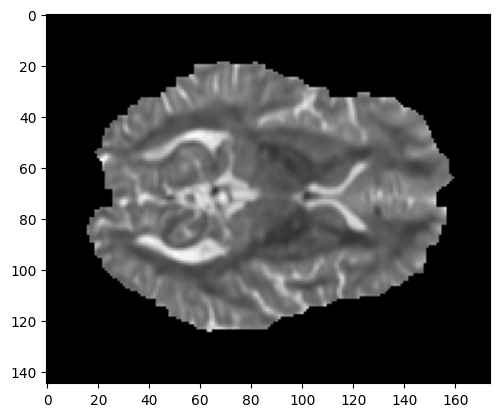

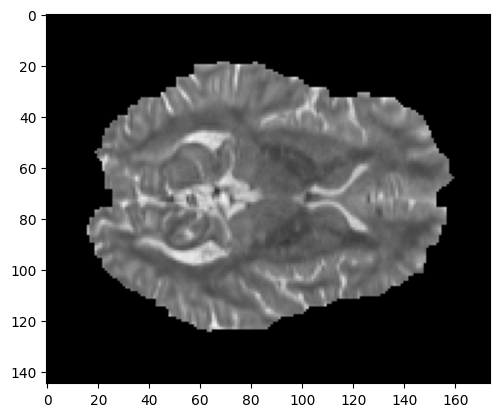

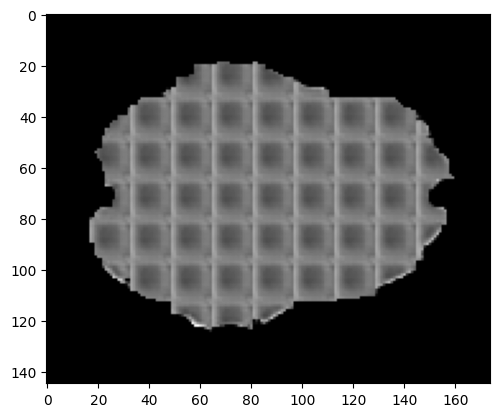

In [16]:
zdim = 60
channel = 0

# plt.imshow(subjects_masks[6][:,:,zdim], cmap='gray')
# plt.figure()
plt.imshow(subjects_lr[6][:,:,zdim,channel]*subjects_masks[6][:,:,zdim], cmap='gray')
plt.figure()
plt.imshow(subjects_hr[6][:,:,zdim,channel]*subjects_masks[6][:,:,zdim], cmap='gray')
plt.figure()
plt.imshow(result_image[:,:,zdim,channel]*subjects_masks[6][:,:,zdim], cmap='gray')

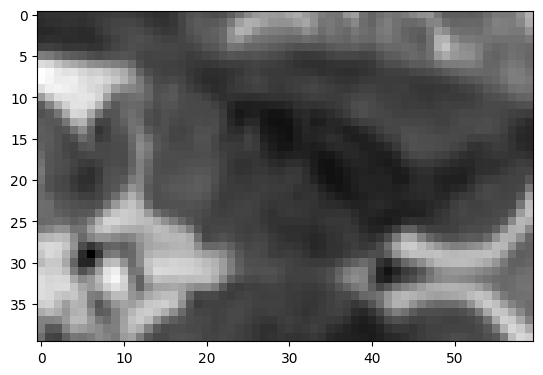

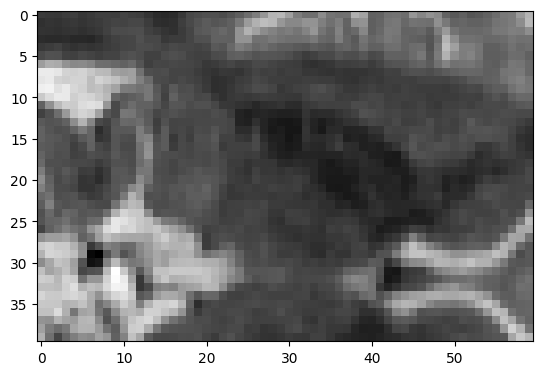

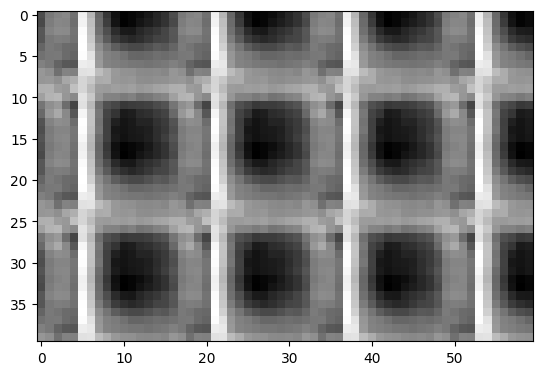

In [17]:
plt.imshow(subjects_lr[6][40:80,60:120,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(subjects_hr[6][40:80,60:120,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(result_image[40:80,60:120,zdim,channel], cmap='gray')

In [ ]:
# generator.save_weights('Model/gen_weights')
# discriminator.save_weights('Model/disc_weights')

In [ ]:
generator.save('Model/generator5xencdec')
discriminator.save('Model/discriminator5xencdec')